In [1]:
import os
import pandas as pd

# 1. Read and concat yearly files
price_list, demand_list = [], []
for year in range(2014, 2026):
    p = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_PriceHOEPPredispOR_{year}.csv',
        skiprows=3
    )
    d = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_Demand_{year}.csv',
        skiprows=3
    )
    price_list.append(p); demand_list.append(d)

price_df  = pd.concat(price_list,  ignore_index=True)
demand_df = pd.concat(demand_list, ignore_index=True)

# 2. Clean names
price_df.columns  = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']] = \
    price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']].ffill()




for df in (price_df, demand_df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Step 1: Combine Date and Hour into naive datetime
    naive_ts = df['Date'] + pd.to_timedelta(df['Hour'] - 1, unit='h')

    # Step 2: Localize with correct DST handling
    df['timestamp'] = naive_ts.dt.tz_localize(
        'Canada/Eastern',
        ambiguous=False,               # Handle fall-back DST automatically
        nonexistent='shift_forward'   # Handle spring-forward DST
    ).dt.tz_convert('UTC')



# 4. Drop bad & duplicates
price_df  = price_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])
demand_df = demand_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])

# 5. Merge price + demand on timestamp
combined_df = pd.merge(
    price_df, demand_df,
    on='timestamp', how='inner',
    suffixes=('_price','_demand')
)
combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

# 6. Cleanup
combined_df = combined_df.drop(
    columns=[
        'Date_price','Hour_price',
        'Date_demand','Hour_demand',
        'OR 10 Min Sync','OR 10 Min non-sync','OR 30 Min', 'Market Demand'
    ],
    errors='ignore'
)
combined_df = combined_df.set_index('timestamp')


print(f"\nFinal shape: {combined_df.shape}")
print(combined_df.isna().sum())
print("Range:", combined_df.index.min(), "→", combined_df.index.max())


Final shape: (99300, 5)
HOEP                  0
Hour 1 Predispatch    0
Hour 2 Predispatch    0
Hour 3 Predispatch    0
Ontario Demand        0
dtype: int64
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [23]:
import os
import pandas as pd

# 1. Config
root = r'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\weather'
cities = ['toronto','kitchener','london','ottawa']
col_map = {
    "Temp (°C)":    "temp",
    "Rel Hum (%)":  "humidity",
    "Wind Spd (km/h)": "wind_speed",
}

city_dfs = []
for city in cities:
    p = os.path.join(root, city)
    dfs = []
    for fname in sorted(os.listdir(p)):
        df = pd.read_csv(os.path.join(p, fname))
        df.columns = df.columns.str.strip().str.replace('"','')

        naive_ts = pd.to_datetime(df['Date/Time (LST)'], errors='coerce')

        df = df[list(col_map)].rename(columns=col_map)


        df['timestamp'] = naive_ts.dt.tz_localize('Canada/Eastern', ambiguous=False, nonexistent='shift_forward').dt.tz_convert('UTC')
        dfs.append(df)
    
   
    city_df = pd.concat(dfs, ignore_index=True)
    city_df  = city_df.drop_duplicates(subset=['timestamp']) 
    city_df = city_df.set_index('timestamp').sort_index()
    # Now forward fill
    city_df = city_df.ffill()
    city_df = city_df.add_suffix(f"_{city}")
    city_dfs.append(city_df)

# inner join across all cities (keeps only timestamps present in every city)
from functools import reduce
weather_df = reduce(lambda L, R: L.join(R, how='inner'), city_dfs)
weather_df = weather_df.sort_index()

print("Shape:", weather_df.shape)
print("Range:", weather_df.index.min(), "→", weather_df.index.max())



Shape: (99300, 12)
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [24]:
# Both have 'timestamp' index in UTC now, accounts for daylight savings
final_df = combined_df.join(weather_df, how='inner')

print("\nMerged shape:", final_df.shape)
print("Merged range:", final_df.index.min(), final_df.index.max())

final_df = final_df.drop(columns=['Hour 1 Predispatch'])
print(final_df.isna().sum())
print(final_df.head())


Merged shape: (99300, 17)
Merged range: 2014-01-01 05:00:00+00:00 2025-05-01 03:00:00+00:00
HOEP                    0
Hour 2 Predispatch      0
Hour 3 Predispatch      0
Ontario Demand          0
temp_toronto            0
humidity_toronto        0
wind_speed_toronto      0
temp_kitchener          0
humidity_kitchener      0
wind_speed_kitchener    0
temp_london             0
humidity_london         0
wind_speed_london       0
temp_ottawa             0
humidity_ottawa         0
wind_speed_ottawa       0
dtype: int64
                            HOEP Hour 2 Predispatch Hour 3 Predispatch  \
timestamp                                                                
2014-01-01 05:00:00+00:00  23.04                 32               35.2   
2014-01-01 06:00:00+00:00  36.64              32.44              21.59   
2014-01-01 07:00:00+00:00  45.85              32.59              32.44   
2014-01-01 08:00:00+00:00  30.88              32.44              22.44   
2014-01-01 09:00:00+00:00  14.36  

In [ ]:
import numpy as np
import pandas as pd
import holidays

# ---------------- CONFIG ----------------
lags = [2, 3, 24, 48, 168]
roll_windows = [3, 23, 167]
ontario_holidays = holidays.Canada(prov='ON')

# ---------------- LOAD + HOURLY ALIGNMENT ----------------
df = final_df.copy()
df = df.reset_index()
# Convert HOEP from string to numeric
df['HOEP'] = pd.to_numeric(df['HOEP'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 2 Predispatch'] = pd.to_numeric(df['Hour 2 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 3 Predispatch'] = pd.to_numeric(df['Hour 3 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ---------------- TIME FEATURES ----------------
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.quarter

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['is_holiday'] = df['timestamp'].dt.date.isin(ontario_holidays).astype(int)
df['is_business_day'] = ((df['day_of_week'] < 5) & (~df['is_holiday'])).astype(int)
df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']


for k in lags:
    df[f'demand_lag_{k}'] = df['Ontario Demand'].shift(k)
    df[f'HOEP_lag_{k}'] = df['HOEP'].shift(k)

    
    # Add lags for each city
    df[f'temp_toronto_lag_{k}'] = df['temp_toronto'].shift(k)
    df[f'humidity_toronto_lag_{k}'] = df['humidity_toronto'].shift(k)
    df[f'wind_speed_toronto_lag_{k}'] = df['wind_speed_toronto'].shift(k)
    
    df[f'temp_kitchener_lag_{k}'] = df['temp_kitchener'].shift(k)
    df[f'humidity_kitchener_lag_{k}'] = df['humidity_kitchener'].shift(k)
    df[f'wind_speed_kitchener_lag_{k}'] = df['wind_speed_kitchener'].shift(k)
    
    df[f'temp_london_lag_{k}'] = df['temp_london'].shift(k)
    df[f'humidity_london_lag_{k}'] = df['humidity_london'].shift(k)
    df[f'wind_speed_london_lag_{k}'] = df['wind_speed_london'].shift(k)
    
    df[f'temp_ottawa_lag_{k}'] = df['temp_ottawa'].shift(k)
    df[f'humidity_ottawa_lag_{k}'] = df['humidity_ottawa'].shift(k)
    df[f'wind_speed_ottawa_lag_{k}'] = df['wind_speed_ottawa'].shift(k)


for win in roll_windows:
    df[f'demand_ma_{win}'] = df['demand_lag_2'].rolling(win).mean()
    df[f'HOEP_ma_{win}'] = df['HOEP_lag_2'].rolling(win).mean()
    
    df[f'temp_toronto_ma_{win}'] = df['temp_toronto_lag_2'].rolling(win).mean()
    df[f'humidity_toronto_ma_{win}'] = df['humidity_toronto_lag_2'].rolling(win).mean()
    df[f'wind_speed_toronto_ma_{win}'] = df['wind_speed_toronto_lag_2'].rolling(win).mean()

df['HOEP_volatility_24h'] = df['HOEP_lag_2'].rolling(23).std()
df['HOEP_range_24h'] = df['HOEP_lag_2'].rolling(23).max() - df['HOEP_lag_2'].rolling(23).min()



df['temp_toronto_squared_lag_2'] = df['temp_toronto_lag_2'] ** 2
df['temp_ottawa_squared_lag_2'] = df['temp_ottawa_lag_2'] ** 2
df['temp_kitchener_squared_lag_2'] = df['temp_kitchener_lag_2'] ** 2
df['temp_london_squared_lag_2'] = df['temp_london_lag_2'] ** 2


df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.set_index('timestamp').sort_index()
df = df.dropna()
cols_to_drop = [
    'Ontario Demand',
    'temp_toronto', 'temp_kitchener', 'temp_ottawa', 'temp_london',
    'humidity_toronto', 'humidity_kitchener', 'humidity_ottawa', 'humidity_london',
    'wind_speed_toronto', 'wind_speed_kitchener', 'wind_speed_ottawa', 'wind_speed_london'
]

df.drop(columns=cols_to_drop, inplace=True)

print(f"Final shape: {df.shape}")
print(df.columns.tolist())

# Safely collect all feature columns (exclude target only)
target_column = 'HOEP'
all_features = df.columns.difference([target_column]).tolist()

# Ensure no duplicates
features = list(dict.fromkeys(all_features))  # preserves order, removes duplicates

print(f"Number of features: {len(features)}")




C:\Users\owner\AppData\Local\Temp\ipykernel_23032\1723522728.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'wind_speed_toronto_ma_{win}'] = df['wind_speed_toronto_lag_2'].rolling(win).mean()
C:\Users\owner\AppData\Local\Temp\ipykernel_23032\1723522728.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'demand_ma_{win}'] = df['demand_lag_2'].rolling(win).mean()
C:\Users\owner\AppData\Local\Temp\ipykernel_23032\1723522728.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

Final shape: (99132, 113)
['HOEP', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'hour', 'day_of_week', 'month', 'year', 'quarter', 'hour_sin', 'hour_cos', 'is_weekend', 'month_sin', 'month_cos', 'week_of_year', 'week_of_year_sin', 'week_of_year_cos', 'day_of_year', 'doy_sin', 'doy_cos', 'is_holiday', 'is_business_day', 'hour_of_week', 'demand_lag_2', 'HOEP_lag_2', 'temp_toronto_lag_2', 'humidity_toronto_lag_2', 'wind_speed_toronto_lag_2', 'temp_kitchener_lag_2', 'humidity_kitchener_lag_2', 'wind_speed_kitchener_lag_2', 'temp_london_lag_2', 'humidity_london_lag_2', 'wind_speed_london_lag_2', 'temp_ottawa_lag_2', 'humidity_ottawa_lag_2', 'wind_speed_ottawa_lag_2', 'demand_lag_3', 'HOEP_lag_3', 'temp_toronto_lag_3', 'humidity_toronto_lag_3', 'wind_speed_toronto_lag_3', 'temp_kitchener_lag_3', 'humidity_kitchener_lag_3', 'wind_speed_kitchener_lag_3', 'temp_london_lag_3', 'humidity_london_lag_3', 'wind_speed_london_lag_3', 'temp_ottawa_lag_3', 'humidity_ottawa_lag_3', 'wind_speed_ottawa_lag_

In [47]:
roll_windows = [3, 23, 167]
ontario_holidays = holidays.Canada(prov='ON')


df2 = final_df.copy()
df2 = df2.reset_index()

# Convert HOEP and predispatch to numeric
df2['HOEP'] = pd.to_numeric(df2['HOEP'].astype(str).str.replace(',', ''), errors='coerce')
df2['Hour 2 Predispatch'] = pd.to_numeric(df2['Hour 2 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df2['Hour 3 Predispatch'] = pd.to_numeric(df2['Hour 3 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

# ---------------- TIME FEATURES ----------------
df2['hour'] = df2['timestamp'].dt.hour
df2['day_of_week'] = df2['timestamp'].dt.dayofweek
df2['month'] = df2['timestamp'].dt.month
df2['year'] = df2['timestamp'].dt.year
df2['quarter'] = df2['timestamp'].dt.quarter

df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24)
df2['is_weekend'] = (df2['day_of_week'] >= 5).astype(int)
df2['month_sin'] = np.sin(2 * np.pi * df2['month'] / 12)
df2['month_cos'] = np.cos(2 * np.pi * df2['month'] / 12)
df2['week_of_year'] = df2['timestamp'].dt.isocalendar().week
df2['week_of_year_sin'] = np.sin(2 * np.pi * df2['week_of_year'] / 52)
df2['week_of_year_cos'] = np.cos(2 * np.pi * df2['week_of_year'] / 52)
df2['day_of_year'] = df2['timestamp'].dt.dayofyear
df2['doy_sin'] = np.sin(2 * np.pi * df2['day_of_year'] / 365)
df2['doy_cos'] = np.cos(2 * np.pi * df2['day_of_year'] / 365)
df2['is_holiday'] = df2['timestamp'].dt.date.isin(ontario_holidays).astype(int)
df2['is_business_day'] = ((df2['day_of_week'] < 5) & (~df2['is_holiday'])).astype(int)
df2['hour_of_week'] = df2['day_of_week'] * 24 + df2['hour']

# Shift time features forward by 2 to match target at t+2
time_cols = [
    'hour', 'day_of_week', 'month', 'year', 'quarter',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'week_of_year', 'week_of_year_sin', 'week_of_year_cos',
    'day_of_year', 'doy_sin', 'doy_cos',
    'is_weekend', 'is_holiday', 'is_business_day',
    'hour_of_week'
]
for col in time_cols:
    df2[col] = df2[col].shift(-2)  # match forecast_horizon

df2['Hour 2 Predispatch'] = df2['Hour 2 Predispatch'].shift(-2)
df2['Hour 3 Predispatch'] = df2['Hour 3 Predispatch'].shift(-2)

for win in roll_windows:
    df2[f'demand_ma_{win}'] = df2['Ontario Demand'].rolling(win).mean()
    df2[f'HOEP_ma_{win}'] = df2['HOEP'].rolling(win).mean()
    
    df2[f'temp_toronto_ma_{win}'] = df2['temp_toronto'].rolling(win).mean()
    df2[f'humidity_toronto_ma_{win}'] = df2['humidity_toronto'].rolling(win).mean()
    df2[f'wind_speed_toronto_ma_{win}'] = df2['wind_speed_toronto'].rolling(win).mean()

df2['HOEP_volatility_24h'] = df2['HOEP'].rolling(23).std()
df2['HOEP_range_24h'] = df2['HOEP'].rolling(23).max() - df2['HOEP'].rolling(23).min()


df2['temp_toronto_squared'] = df2['temp_toronto'] ** 2
df2['temp_ottawa_squared'] = df2['temp_ottawa'] ** 2
df2['temp_kitchener_squared'] = df2['temp_kitchener'] ** 2
df2['temp_london_squared'] = df2['temp_london'] ** 2
df2 = df2.dropna()
print(df2.head())
print(df2.shape)

target_column = 'HOEP'

df2["timestamp"] = pd.to_datetime(df2["timestamp"], utc=True)
df2 = df2.set_index('timestamp').sort_index()

other_features = df2.columns.difference([target_column]).tolist()
# Ensure no duplicates
lstm_features = list(dict.fromkeys(other_features))  # preserves order, removes duplicates

print(f"Number of features: {len(lstm_features)}")


                    timestamp   HOEP  Hour 2 Predispatch  Hour 3 Predispatch  \
166 2014-01-08 03:00:00+00:00  88.60               42.02               44.50   
167 2014-01-08 04:00:00+00:00  56.25               55.20               42.00   
168 2014-01-08 05:00:00+00:00  48.82               59.00               44.49   
169 2014-01-08 06:00:00+00:00  47.64               59.00               45.12   
170 2014-01-08 07:00:00+00:00  44.22               56.04               47.26   

     Ontario Demand  temp_toronto  humidity_toronto  wind_speed_toronto  \
166           19966         -15.1              74.0                45.0   
167           18734         -14.9              76.0                39.0   
168           17675         -15.1              73.0                37.0   
169           17259         -15.3              73.0                42.0   
170           17034         -15.0              76.0                35.0   

     temp_kitchener  humidity_kitchener  ...  HOEP_ma_167  \
166    

In [48]:
# 3-way split for proper validation
train_cutoff = pd.Timestamp("2023-01-01 00:00:00", tz="UTC")
val_cutoff = pd.Timestamp("2024-01-01 00:00:00", tz="UTC")
final_cutoff = pd.Timestamp("2025-01-01 00:00:00", tz='UTC')

df_train = df[df.index < train_cutoff]          # 2014-2022
df_val = df[(df.index >= train_cutoff) & (df.index < val_cutoff)]  # 2023
df_test = df[(df.index >= val_cutoff ) & (df.index < final_cutoff)]             # 2024


X_train = df_train[features].apply(pd.to_numeric, errors="coerce")
y_train = pd.to_numeric(df_train[target], errors="coerce")

X_val = df_val[features].apply(pd.to_numeric, errors="coerce")
y_val = pd.to_numeric(df_val[target], errors="coerce")

X_test = df_test[features].apply(pd.to_numeric, errors="coerce")
y_test = pd.to_numeric(df_test[target], errors="coerce")

# Save column names before scaling
feature_names_ELM = X_train.columns.tolist()



In [49]:
# Create LSTM splits
lstm_train = df2[df2.index < train_cutoff]
lstm_val = df2[(df2.index >= train_cutoff) & (df2.index < val_cutoff)]
lstm_test = df2[(df2.index >= val_cutoff) & (df2.index < final_cutoff)]



In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np


# Hour 2
rmse_2 = np.sqrt(mean_squared_error(y_test, df_test["Hour 2 Predispatch"]))
mae_2  = mean_absolute_error(y_test, df_test["Hour 2 Predispatch"])

# Hour 3
rmse_3 = np.sqrt(mean_squared_error(y_test, df_test["Hour 3 Predispatch"]))
mae_3  = mean_absolute_error(y_test, df_test["Hour 3 Predispatch"])



print(f"Hour 2 Predispatch RMSE: {rmse_2:.2f} CAD/MWh")
print(f"Hour 2 Predispatch MAE : {mae_2:.2f} CAD/MWh")
print(f"Hour 3 Predispatch RMSE: {rmse_3:.2f} CAD/MWh")
print(f"Hour 3 Predispatch MAE : {mae_3:.2f} CAD/MWh")

Hour 2 Predispatch RMSE: 29.67 CAD/MWh
Hour 2 Predispatch MAE : 11.44 CAD/MWh
Hour 3 Predispatch RMSE: 28.38 CAD/MWh
Hour 3 Predispatch MAE : 10.54 CAD/MWh


In [52]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Config
n_steps = 6          # use last 6 hours
forecast_horizon = 2   # predict t using data up to t-2
batch_size = 64
epochs = 25
lstm_units = 64
target_col = "HOEP"

# Prepare features
lstm_train = lstm_train.copy()
lstm_val = lstm_val.copy()
lstm_test = lstm_test.copy()

# Shift HOEP by -2 to predict t+2
lstm_train['y'] = lstm_train[target_col].shift(-forecast_horizon)
lstm_val['y']   = lstm_val[target_col].shift(-forecast_horizon)
lstm_test['y']  = lstm_test[target_col].shift(-forecast_horizon)


lstm_train = lstm_train.dropna(subset=['y'])
lstm_val = lstm_val.dropna(subset=['y'])
lstm_test = lstm_test.dropna(subset=['y'])

# Raw feature matrices
X_train_lstm_raw = lstm_train[lstm_features].copy()
X_val_lstm_raw = lstm_val[lstm_features].copy()
X_test_lstm_raw = lstm_test[lstm_features].copy()

y_train_lstm = lstm_train['y'].values
y_val_lstm = lstm_val['y'].values
y_test_lstm = lstm_test['y'].values

# Scale all features
lstm_scaler = StandardScaler()
X_train_lstm = lstm_scaler.fit_transform(X_train_lstm_raw)
X_val_lstm = lstm_scaler.transform(X_val_lstm_raw)
X_test_lstm = lstm_scaler.transform(X_test_lstm_raw)

# Target

y_scaler = StandardScaler()
y_train_lstm_scaled = y_scaler.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
y_val_lstm_scaled   = y_scaler.transform(y_val_lstm.reshape(-1, 1)).flatten()
y_test_lstm_scaled  = y_scaler.transform(y_test_lstm.reshape(-1, 1)).flatten()

# Build sequences

X_train_seq, y_train_seq = [], []
for i in range(n_steps, len(X_train_lstm)):
    X_train_seq.append(X_train_lstm[i - n_steps:i])
    y_train_seq.append(y_train_lstm_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

X_val_seq, y_val_seq = [], []
for i in range(n_steps, len(X_val_lstm)):
    X_val_seq.append(X_val_lstm[i - n_steps:i])
    y_val_seq.append(y_val_lstm_scaled[i])
X_val_seq = np.array(X_val_seq)
y_val_seq = np.array(y_val_seq)

X_test_seq, y_test_seq = [], []
for i in range(n_steps, len(X_test_lstm)):
    X_test_seq.append(X_test_lstm[i - n_steps:i])
    y_test_seq.append(y_test_lstm_scaled[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Model architecture

tf.random.set_seed(42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train model

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = early_stop

# Train model
start_time = time.time()
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=False,
    verbose=1
)
train_time = time.time() - start_time

# Predict and evaluate

y_pred_scaled = model.predict(X_test_seq).flatten()
y_pred_lstm = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true_lstm = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
r2 = r2_score(y_true_lstm, y_pred_lstm)

print(f"Test RMSE     : {rmse:.2f}")
print(f"Test MAE      : {mae:.2f}")
print(f"Test R²       : {r2:.3f}")
print(f"Train Time    : {train_time:.2f} seconds")

from joblib import dump

# Save model
model.save("lstm_model.h5")

# Save scaler
dump(y_scaler, "lstm_scaler.joblib")


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.1021 - val_loss: 0.3074
Epoch 2/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.8953 - val_loss: 0.2657
Epoch 3/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.8279 - val_loss: 0.2700
Epoch 4/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7827 - val_loss: 0.2658
Epoch 5/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7839 - val_loss: 0.2537
Epoch 6/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7703 - val_loss: 0.2570
Epoch 7/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.7581 - val_loss: 0.2536
Epoch 8/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7659 - val_loss: 0.2567
Epoch 9/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7246 - val_loss: 0.2578
Epoch 10/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.7420 - val_loss: 0.2615
Epoch 11/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7079 - val_loss: 0.2583
Epoch 12/25
1230/1230

['lstm_scaler.joblib']

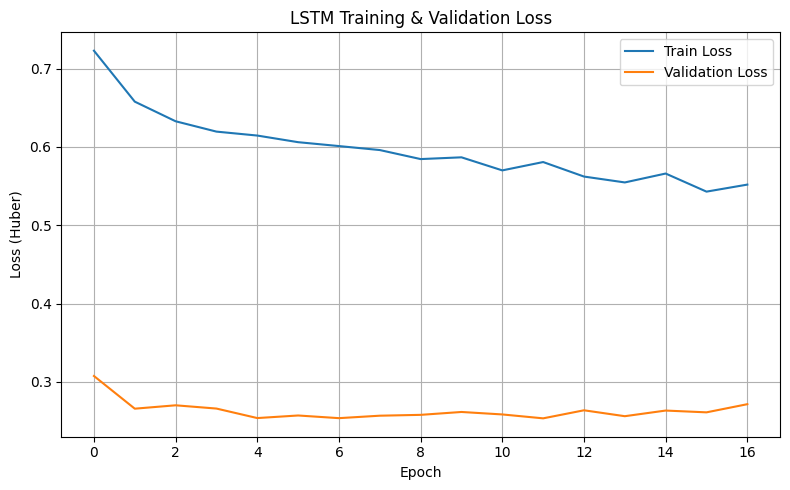

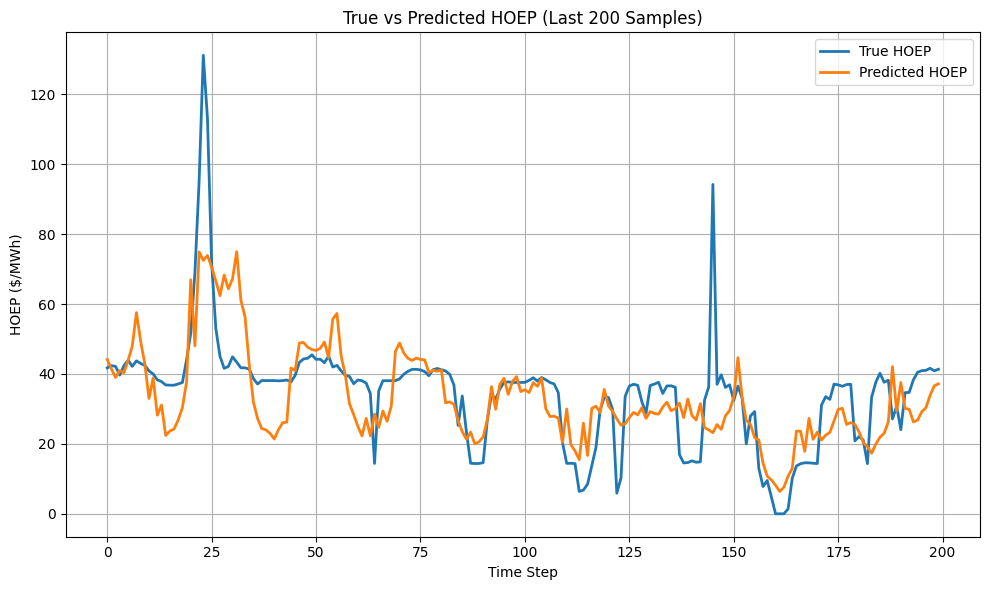

In [53]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()

# True vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_true_lstm[-200:], label='True HOEP', linewidth=2)
plt.plot(y_pred_lstm[-200:], label='Predicted HOEP', linewidth=2)
plt.title("True vs Predicted HOEP (Last 200 Samples)")
plt.xlabel("Time Step")
plt.ylabel("HOEP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("hoep_vs_prediction.png", dpi=300)
plt.show()


In [54]:
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd  

np.random.seed(42)

# Track the best across all k-values
best_rmse = float('inf')
best_n_hidden = None
best_k = None
best_selector = None
best_selected_feature_names = None
best_train_time = None
best_scaler = None

for k in [10, 20, 30, 40, 50, 60]:

    # Step 1: Feature selection (on raw, unscaled data)
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train, y_train)

    # Step 2: Transform raw data with selector
    X_train_sel_raw = selector.transform(X_train)
    X_val_sel_raw   = selector.transform(X_val)
    X_test_sel_raw  = selector.transform(X_test)

    
    scaler = StandardScaler()
    X_train_sel = scaler.fit_transform(X_train_sel_raw)
    X_val_sel   = scaler.transform(X_val_sel_raw)
    X_test_sel  = scaler.transform(X_test_sel_raw)

    print("Hyperparameter Tuning Results:")

    for n_hidden in [100, 250, 500, 750]:
        start_time = time.time()
        
        W_in = np.random.randn(X_train_sel.shape[1], n_hidden)
        H_train = np.maximum(0, X_train_sel @ W_in)
        H_val = np.maximum(0, X_val_sel @ W_in)
        W_out = np.linalg.pinv(H_train) @ y_train
        
        train_time = time.time() - start_time
        
        y_val_pred = H_val @ W_out
        val_rmse = np.sqrt(np.mean((y_val - y_val_pred)**2))
        
        print(f"n_hidden={n_hidden}: Validation RMSE = {val_rmse:.2f}, Train Time = {train_time:.3f}s")
        
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_n_hidden = n_hidden
            best_k = k
            best_selector = selector
            best_scaler = scaler
            best_train_time = train_time
            best_selected_feature_names = X_train.columns[selector.get_support()]



print("Final Best ELM Model:")
print(f"Best k (num features): {best_k}")
print(f"Best n_hidden        : {best_n_hidden}")
print(f"Best validation RMSE : {best_rmse:.2f}")
print(f"Train Time           : {best_train_time:.3f}s")

print("\nTop Features selected by SelectKBest (ELM):")
for i, feat in enumerate(best_selected_feature_names, 1):
    print(f"{i:2d}. {feat}")


np.random.seed(42)

X_train_sel_raw = best_selector.transform(X_train)
X_test_sel_raw  = best_selector.transform(X_test)

X_train_sel = best_scaler.fit_transform(X_train_sel_raw)
X_test_sel  = best_scaler.transform(X_test_sel_raw)

W_in = np.random.randn(X_train_sel.shape[1], best_n_hidden)
H_train = np.maximum(0, X_train_sel @ W_in)
H_test = np.maximum(0, X_test_sel @ W_in)
W_out = np.linalg.pinv(H_train) @ y_train

y_test_pred = H_test @ W_out

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

print("\nFinal Test Results:")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test R²  : {r2:.3f}")


joblib.dump({
    "W_in": W_in,
    "W_out": W_out,
    "n_hidden": best_n_hidden,
    "scaler": best_scaler,
    "selector": best_selector
}, "elm_model.pkl")


y_test_s = pd.Series(y_test, index=df_test.index)
y_pred_s = pd.Series(y_test_pred, index=df_test.index)

Hyperparameter Tuning Results:
n_hidden=100: Validation RMSE = 19.68, Train Time = 1.341s
n_hidden=250: Validation RMSE = 19.45, Train Time = 3.542s
n_hidden=500: Validation RMSE = 19.51, Train Time = 11.970s
n_hidden=750: Validation RMSE = 19.32, Train Time = 16.595s
Hyperparameter Tuning Results:
n_hidden=100: Validation RMSE = 17.16, Train Time = 1.373s
n_hidden=250: Validation RMSE = 16.60, Train Time = 3.215s
n_hidden=500: Validation RMSE = 16.59, Train Time = 7.127s
n_hidden=750: Validation RMSE = 16.87, Train Time = 12.229s
Hyperparameter Tuning Results:
n_hidden=100: Validation RMSE = 16.99, Train Time = 1.268s
n_hidden=250: Validation RMSE = 16.79, Train Time = 3.037s
n_hidden=500: Validation RMSE = 16.51, Train Time = 7.119s
n_hidden=750: Validation RMSE = 16.58, Train Time = 12.365s
Hyperparameter Tuning Results:
n_hidden=100: Validation RMSE = 17.23, Train Time = 1.310s
n_hidden=250: Validation RMSE = 16.53, Train Time = 3.051s
n_hidden=500: Validation RMSE = 16.37, Train T